In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

### Load data and format it

In [152]:
df = pd.read_csv('/home/max/projects/activitysynth/activitysynth/data/15.skims.csv.gz')

In [153]:
df.rename(columns={
        'generalizedCost': 'gen_cost', 'origTaz': 'from_zone_id',
        'destTaz': 'to_zone_id'}, inplace=True)

In [154]:
df['gen_tt'] = df['generalizedTimeInS'] / 60
df['tt'] = df['travelTimeInS'] / 60

In [143]:
mtc_skims = pd.read_csv('/home/data/spring_2019/base/mtc_skims.csv', index_col=0)

In [144]:
mtc = mtc_skims[['orig', 'dest', 'da_distance_AM']]

In [145]:
mtc.rename(
    columns={'orig': 'from_zone_id', 'dest': 'to_zone_id'},
    inplace=True)
mtc.set_index(['from_zone_id', 'to_zone_id'], inplace=True)

In [146]:
mtc['dist'] = mtc['da_distance_AM'] * 1609.34

/home/max/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Make lookup table

In [155]:
# replace zero-valued skim dists with values from MTC
if len(df.loc[df['distanceInM'] == 0, 'distanceInM']) > 0:
        df.loc[df['distanceInM'] == 0, 'distanceInM'] = mtc.loc[
            pd.MultiIndex.from_frame(df.loc[df['distanceInM'] == 0, [
                'from_zone_id', 'to_zone_id']]), 'dist'].values

In [156]:
# use MTC dists for all intra-taz distances
intra_taz_mask = df['from_zone_id'] == df['to_zone_id']
# df.loc[intra_taz_mask, 'distanceInM'] = mtc.loc[pd.MultiIndex.from_frame(
#     df.loc[intra_taz_mask, ['from_zone_id', 'to_zone_id']]), 'dist'].values

df.loc[intra_taz_mask, 'distanceInM'] = mtc.loc[
            pd.MultiIndex.from_arrays(list(zip(*df.loc[
                intra_taz_mask,
                ['from_zone_id', 'to_zone_id']].values))),
            'dist'].values

In [157]:
df['gen_time_per_m'] = df['gen_tt'] / df['distanceInM']
df['gen_cost_per_m'] = df['gen_cost'] / df['distanceInM']
df['time_per_m'] = df['tt'] / df['distanceInM']
df.loc[df['hour'].isin([7, 8, 9]), 'period'] = 'AM'
df_am = df[df['period'] == 'AM']
df_am = df_am.replace([np.inf, -np.inf], np.nan)
df_am = df_am.loc[df_am.index.repeat(df_am.numObservations)]
am_lookup = df_am[[
    'mode', 'time_per_m', 'gen_time_per_m', 'gen_cost_per_m']].dropna().groupby(
        ['mode']).mean().reset_index()

In [116]:
# iter0
am_lookup

,mode,time_per_m,gen_time_per_m,gen_cost_per_m
0,BIKE,0.003422,0.003445,0.001511
1,CAR,0.000648,0.000632,0.000283
2,DRIVE_TRANSIT,0.001353,0.001758,0.000772
3,RIDE_HAIL,0.000734,0.001937,0.003503
4,RIDE_HAIL_POOLED,0.000731,0.002220,0.001899
5,RIDE_HAIL_TRANSIT,0.001259,0.001643,0.001131
6,WALK,0.017617,0.017617,0.005062
7,WALK_TRANSIT,0.002836,0.004063,0.002156


In [128]:
# iter2
am_lookup

,mode,time_per_m,gen_time_per_m,gen_cost_per_m
0,BIKE,0.003416,0.003437,0.001508
1,CAR,0.000753,0.000731,0.000333
2,DRIVE_TRANSIT,0.001537,0.001966,0.000862
3,RIDE_HAIL,0.000849,0.002637,0.004451
4,RIDE_HAIL_POOLED,0.000798,0.002509,0.002103
5,RIDE_HAIL_TRANSIT,0.001375,0.001835,0.001257
6,WALK,0.017634,0.017634,0.005173
7,WALK_TRANSIT,0.002986,0.004559,0.002324


In [139]:
# iter2-hacked
am_lookup

,mode,time_per_m,gen_time_per_m,gen_cost_per_m
0,BIKE,0.003449,0.003462,0.001455
1,CAR,0.000758,0.000748,0.000338
2,DRIVE_TRANSIT,0.001615,0.002074,0.000924
3,RIDE_HAIL,0.000885,0.002962,0.005037
4,RIDE_HAIL_POOLED,0.000811,0.002841,0.002252
5,RIDE_HAIL_TRANSIT,0.001466,0.001981,0.001272
6,WALK,0.017287,0.017287,0.005143
7,WALK_TRANSIT,0.003405,0.005100,0.002807


In [150]:
# iter15
am_lookup

,mode,time_per_m,gen_time_per_m,gen_cost_per_m
0,BIKE,0.003421,0.003439,0.001683
1,CAR,0.000805,0.000782,0.000347
2,DRIVE_TRANSIT,0.001557,0.001980,0.000938
3,RIDE_HAIL,0.000903,0.002664,0.004540
4,RIDE_HAIL_POOLED,0.000842,0.002452,0.001985
5,RIDE_HAIL_TRANSIT,0.001394,0.001890,0.001566
6,WALK,0.018356,0.018356,0.005963
7,WALK_TRANSIT,0.002960,0.004461,0.002437


In [14]:
# morning averages
df_am_avg = df_am[[
    'from_zone_id', 'to_zone_id', 'mode', 'gen_tt',
    'gen_cost']].groupby(
    ['from_zone_id', 'to_zone_id', 'mode']).mean().reset_index()

# long to wide
df_am_pivot = df_am_avg.pivot_table(
    index=['from_zone_id', 'to_zone_id'], columns='mode')
df_am_pivot.columns = ['_'.join(col) for col in df_am_pivot.columns.values]

# combine with mtc-based dists
merged = pd.merge(
    mtc[['dist']], df_am_pivot, left_index=True, right_index=True,
    how='left')

In [15]:
# impute
for mode in am_lookup['mode'].values:
    for impedance in ['gen_tt', 'gen_cost']:
        if impedance == 'gen_tt':
            lookup_col = 'gen_time_per_m'
        elif impedance == 'gen_cost':
            lookup_col = 'gen_cost_per_m'
        colname = impedance + '_' + mode
        lookup_val = am_lookup.loc[
            am_lookup['mode'] == mode, lookup_col].values[0]
        merged.loc[pd.isnull(merged[colname]), colname] = merged.loc[
            pd.isnull(merged[colname]), 'dist'] * lookup_val

In [16]:
len(merged)

2114116

In [17]:
merged.describe()

,dist,gen_cost_BIKE,gen_cost_CAR,gen_cost_DRIVE_TRANSIT,gen_cost_RIDE_HAIL,gen_cost_RIDE_HAIL_POOLED,gen_cost_RIDE_HAIL_TRANSIT,gen_cost_WALK,gen_cost_WALK_TRANSIT,gen_tt_BIKE,gen_tt_CAR,gen_tt_DRIVE_TRANSIT,gen_tt_RIDE_HAIL,gen_tt_RIDE_HAIL_POOLED,gen_tt_RIDE_HAIL_TRANSIT,gen_tt_WALK,gen_tt_WALK_TRANSIT
count,2.114116e+06,2.114116e+06,2.114116e+06,2.114116e+06,2.114116e+06,2.114116e+06,2.114116e+06,2.114116e+06,2.114116e+06,2.114116e+06,2.114116e+06,2.114116e+06,2.114116e+06,2.114116e+06,2.114116e+06,2.114116e+06,2.114116e+06
mean,6.501095e+04,1.080722e+02,1.939048e+01,6.004497e+01,2.914714e+02,1.291821e+02,1.013899e+02,3.505393e+02,1.458226e+02,2.236464e+02,4.648250e+01,1.292359e+02,1.715746e+02,1.595257e+02,1.227681e+02,1.158485e+03,2.896969e+02
std,3.899659e+04,6.485514e+01,1.203388e+01,3.603267e+01,1.749028e+02,7.750777e+01,6.081854e+01,2.103338e+02,8.768796e+01,1.341689e+02,2.717742e+01,7.753759e+01,1.029574e+02,9.571619e+01,7.364165e+01,6.948757e+02,1.740591e+02
min,1.609340e+02,1.055556e-01,6.700528e-03,1.486595e-01,7.216429e-01,3.198363e-01,2.509902e-01,1.521011e-03,3.613219e-01,2.000000e-01,1.666667e-02,3.199515e-01,4.247988e-01,3.949702e-01,3.039104e-01,3.737374e-03,6.666667e-02
25%,3.561469e+04,5.921278e+01,1.155346e+01,3.288349e+01,1.596274e+02,7.071581e+01,5.554414e+01,1.921021e+02,7.974374e+01,1.224686e+02,2.778167e+01,7.077326e+01,9.396549e+01,8.732791e+01,6.725537e+01,6.348994e+02,1.583814e+02
50%,6.015713e+04,1.000169e+02,1.788572e+01,5.556893e+01,2.697501e+02,1.195228e+02,9.382015e+01,3.244218e+02,1.350260e+02,2.069565e+02,4.333667e+01,1.195979e+02,1.587898e+02,1.476004e+02,1.136017e+02,1.071930e+03,2.681791e+02
75%,8.696873e+04,1.445937e+02,2.475072e+01,8.033560e+01,3.899758e+02,1.728396e+02,1.356351e+02,4.689756e+02,1.952583e+02,2.991955e+02,5.997500e+01,1.729018e+02,2.295613e+02,2.134419e+02,1.642332e+02,1.549682e+03,3.878084e+02
max,2.840485e+05,4.722573e+02,7.482413e+02,2.623840e+02,1.273700e+03,5.645111e+02,4.429977e+02,2.904426e+03,6.377331e+02,9.772023e+02,4.489500e+02,5.647143e+02,7.497698e+02,6.971224e+02,5.364018e+02,5.061416e+03,1.266621e+03


### Plots

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbe5962bb00>,
      dtype=object)

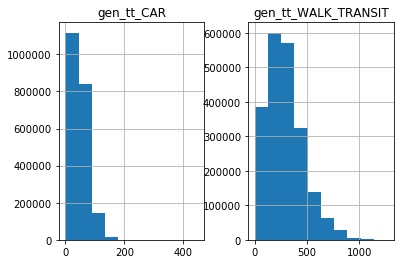

In [18]:
merged[['gen_tt_WALK_TRANSIT', 'gen_tt_CAR']].hist()

In [19]:
merged['walking_speed_mph'] = merged['dist'] / merged['gen_tt_WALK'] / 60 * 2.23694
merged['drive_speed_mph'] = merged['dist'] / merged['gen_tt_CAR'] / 60 * 2.23694

In [20]:
merged.head()

dist  gen_cost_BIKE  gen_cost_CAR  \
from_zone_id to_zone_id                                           
1            1            193.1208       0.321081      0.053938   
             2            386.2416       0.642163      0.006716   
             3            708.1096       1.177299      0.449323   
             4            659.8294       1.097028      0.384770   
             5           1094.3512       1.819462      0.436779   

                         gen_cost_DRIVE_TRANSIT  gen_cost_RIDE_HAIL  \
from_zone_id to_zone_id                                               
1            1                         0.178391            0.865972   
             2                         0.356783            1.731943   
             3                         0.654102            3.175229   
             4                         0.609504            2.958736   
             5                         1.010885            4.907172   

                         gen_cost_RIDE_HAIL_POOLED  \
from_zone_id to_zone_id                              
1            1                            0.383804   
             2                            0.767607   
             3                            1.407280   
             4                            1.311329   
             5                            2.174887   

                         gen_cost_RIDE_HAIL_TRANSIT  gen_cost_WALK  \
from_zone_id to_zone_id                                              
1            1                             0.301188       1.041204   
             2                             0.602377       2.082408   
             3                             1.104357       3.817747   
             4                             1.029060       2.911428   
             5                             1.706734       5.900155   

                         gen_cost_WALK_TRANSIT  gen_tt_BIKE  gen_tt_CAR  \
from_zone_id to_zone_id                                                   
1            1                        3.093391     0.664387    0.133333   
             2                        0.867173     1.328774    0.016667   
             3                        1.589816     2.436085    1.110000   
             4                        1.481420     2.269988    0.951667   
             5                        2.456989     3.764859    1.075000   

                         gen_tt_DRIVE_TRANSIT  gen_tt_RIDE_HAIL  \
from_zone_id to_zone_id                                           
1            1                       0.383942          0.509759   
             2                       0.767884          1.019517   
             3                       1.407786          1.869115   
             4                       1.311801          1.741675   
             5                       2.175670          2.888632   

                         gen_tt_RIDE_HAIL_POOLED  gen_tt_RIDE_HAIL_TRANSIT  \
from_zone_id to_zone_id                                                      
1            1                          0.473964                  0.364692   
             2                          0.947928                  0.729385   
             3                          1.737869                  1.337206   
             4                          1.619378                  1.246033   
             5                          2.685797                  2.066591   

                         gen_tt_WALK  gen_tt_WALK_TRANSIT  walking_speed_mph  \
from_zone_id to_zone_id                                                        
1            1              3.441189             3.133333           2.092298   
             2              6.882378             1.722317           2.092298   
             3             12.617693             3.157581           2.092298   
             4              7.950000             2.942292           3.094337   
             5             19.500071             4.879898           2.092298   

                         drive_speed_mph  
from_zone_id to_zone_id                   
1 

Text(0.5, 1.0, 'iter2')

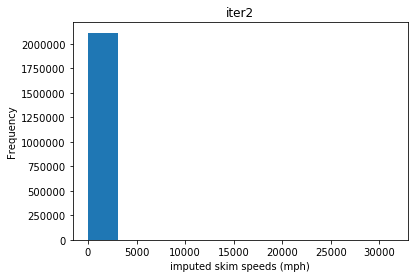

In [56]:
fig, ax = plt.subplots()
merged['drive_speed_mph'].plot(kind='hist', ax=ax)
# ax.set_xlim(0, 100)
ax.set_xlabel('imputed skim speeds (mph)')
ax.set_title('iter2')

### map

In [71]:
taz_geom = pd.read_csv('/home/max/avg_zone_xy.csv')

In [72]:
taz_geom.head()

,zone_id,x,y
0,1,-122.398631,37.793468
1,2,-122.402026,37.792296
2,3,-122.405749,37.791363
3,4,-122.402485,37.789787
4,5,-122.405922,37.788372


In [74]:
merged = merged.reset_index()

In [76]:
merged = pd.merge(merged, taz_geom, left_on='from_zone_id', right_on='zone_id')

In [77]:
merged = pd.merge(merged, taz_geom, left_on='to_zone_id', right_on='zone_id', suffixes=('_from','_to'))

In [78]:
merged.head()

,from_zone_id,to_zone_id,dist,gen_cost_BIKE,gen_cost_CAR,gen_cost_DRIVE_TRANSIT,gen_cost_RIDE_HAIL,gen_cost_RIDE_HAIL_POOLED,gen_cost_RIDE_HAIL_TRANSIT,gen_cost_WALK,...,gen_tt_WALK,gen_tt_WALK_TRANSIT,walking_speed_mph,drive_speed_mph,zone_id_from,x_from,y_from,zone_id_to,x_to,y_to
0,1,1,193.1208,0.347329,0.529577,0.602550,0.872740,0.376302,0.871092,1.395318,...,3.786922,1344.189438,1.901279,16.775103,1,-122.398631,37.793468,1,-122.398631,37.793468
1,2,1,595.4558,1.070931,1.632862,1.857863,2.690948,1.160264,2.685866,4.302232,...,11.676343,4144.584100,1.901279,16.775103,2,-122.402026,37.792296,1,-122.398631,37.793468
2,3,1,917.3238,4.885812,2.515490,2.862113,4.145514,1.787434,4.137685,2.223495,...,9.408333,6384.899830,3.635072,16.775103,3,-122.405749,37.791363,1,-122.398631,37.793468
3,4,1,547.1756,0.984099,1.500468,1.707225,2.472763,1.066189,2.468093,3.953402,...,10.729613,9.383333,1.901279,16.775103,4,-122.402485,37.789787,1,-122.398631,37.793468
4,5,1,1126.5380,2.026086,3.089198,3.514875,5.090982,2.195095,5.081368,8.139357,...,22.090379,7841.105054,1.901279,16.775103,5,-122.405922,37.788372,1,-122.398631,37.793468


In [79]:
from shapely.geometry import LineString

In [83]:
merged.head()

,from_zone_id,to_zone_id,dist,gen_cost_BIKE,gen_cost_CAR,gen_cost_DRIVE_TRANSIT,gen_cost_RIDE_HAIL,gen_cost_RIDE_HAIL_POOLED,gen_cost_RIDE_HAIL_TRANSIT,gen_cost_WALK,...,gen_tt_WALK,gen_tt_WALK_TRANSIT,walking_speed_mph,drive_speed_mph,zone_id_from,x_from,y_from,zone_id_to,x_to,y_to
0,1,1,193.1208,0.347329,0.529577,0.602550,0.872740,0.376302,0.871092,1.395318,...,3.786922,1344.189438,1.901279,16.775103,1,-122.398631,37.793468,1,-122.398631,37.793468
1,2,1,595.4558,1.070931,1.632862,1.857863,2.690948,1.160264,2.685866,4.302232,...,11.676343,4144.584100,1.901279,16.775103,2,-122.402026,37.792296,1,-122.398631,37.793468
2,3,1,917.3238,4.885812,2.515490,2.862113,4.145514,1.787434,4.137685,2.223495,...,9.408333,6384.899830,3.635072,16.775103,3,-122.405749,37.791363,1,-122.398631,37.793468
3,4,1,547.1756,0.984099,1.500468,1.707225,2.472763,1.066189,2.468093,3.953402,...,10.729613,9.383333,1.901279,16.775103,4,-122.402485,37.789787,1,-122.398631,37.793468
4,5,1,1126.5380,2.026086,3.089198,3.514875,5.090982,2.195095,5.081368,8.139357,...,22.090379,7841.105054,1.901279,16.775103,5,-122.405922,37.788372,1,-122.398631,37.793468


In [84]:
merged['geometry'] = merged.apply(lambda k: LineString([(k.x_from, k.y_from,), (k.x_to, k.y_to) ]), axis=1)

In [86]:
import geopandas as gpd

In [88]:
gdf = gpd.GeoDataFrame(merged, crs='epsg:4326', geometry='geometry')

In [89]:
gdf.to_file('~/skims_w_geom')